# Multi-Armed Bandit Line Jump

In this notebook, we test our knowledge of multi-armed bandits on the a line wark problem. The formulation of a line walk problem is as follows:
- We have a line scaled from 0 to $\texttt{max\_scale}$.
- We set sample random two variables $\texttt{agent\_position}$ and $\texttt{goal}$ in the line scale. These are:
    - $\texttt{agent\_position}$: our agent position
    - $\texttt{goal}$: our goal position
- We can perfom a jump from a set of n jumps which basically determines how the agent towards to the goal.
- Objective: Find the jump to makes the agent reach the goal (or at least be the closest possible).

### Import

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(int(time.time()))
%matplotlib inline

## Environment

We start by creating the environment which is a fairly simple one.
- We generate the goal and the agent position
- Our reward at a given time step is given by:

$$ P_t = \frac{1}{|\texttt{agent\_positon}_t - \texttt{goal}| + 1}$$

$$

R_t = X \sim \mathrm{Bern}(P_t)
$$

In [2]:
from rl_lab.environments.bandits import LineWalkEnvironment

## Agent

- The only information our greedy agent has is:
    - The set of actions it can perform.
    - The expected gain of each action along over time.
- We update our expected reward for each action according to the following formula.

$$
Q_t(a)=\frac{R_1+R_2+\cdots+R_{N_t(a)}}{N_t(a)}
$$

- To compute it recursively, we use the following formula.

$$
Q_t(a)= Q_{t - 1}(a)+ \frac{1}{N_t(a)} (R_{N_t(a)} - Q_{t - 1}(a))
$$

You can check th code for the used agent at []()

In [3]:
from rl_lab.agents.bandits import Jumper

## Training

Now, let us create the function that runs the different experiments and returns the metrics of interest to compare different methods. We implement these experiments such that $10^{th}$ action is always the best action.

In [4]:
from rl_lab.runners import run_bandits_experiments

The next steps is to run a simulation with different approach to solving the multi-armed bandit problem. These approaches are:
    
- Greedy Solution (only select best action)
- $\epsilon$-greedy (select best action with probability 1 - $\epsilon$)
- The same previous methods but we constant step size instead of the using the reciprocal of the number of times the action for which we obtained a reward was taken.

In [11]:
num_actions = 10
line_length = 256
timesteps = 1000
num_experiments = 100

specs = {
    "$\epsilon=0.1$": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.1
        },
        "color": "black"
    },
    "$\epsilon=0.01$": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.01
        },
        "color": "red"
    },
    "$\epsilon=0$ (greedy)": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.0
        },
        "color": "green"
    },"$\epsilon=0.1$ (constant)": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.1,
            "has_constant_step": True
        },
        "color": "blue"
    },
    "$\epsilon=0.01$ (constant)": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.01,
            "has_constant_step": True
        },
        "color": "brown"
    },
    "$\epsilon=0$ (greedy,constant)": {
        "agent": Jumper,
        "params": {
            "epsilon": 0.0,
            "has_constant_step": True
        },
        "color": "grey"
    },
}

results = run_bandits_experiments(specs, LineWalkEnvironment, timesteps, num_actions, num_experiments, line_length)

Now we will plot different experiments.

In [12]:
from rl_lab.plotters import plot_lines, plot_bars

<AxesSubplot: title={'center': 'Average reward (per actions) over 100 experiments'}, xlabel='Actions', ylabel='Average Reward'>

<Figure size 640x480 with 0 Axes>

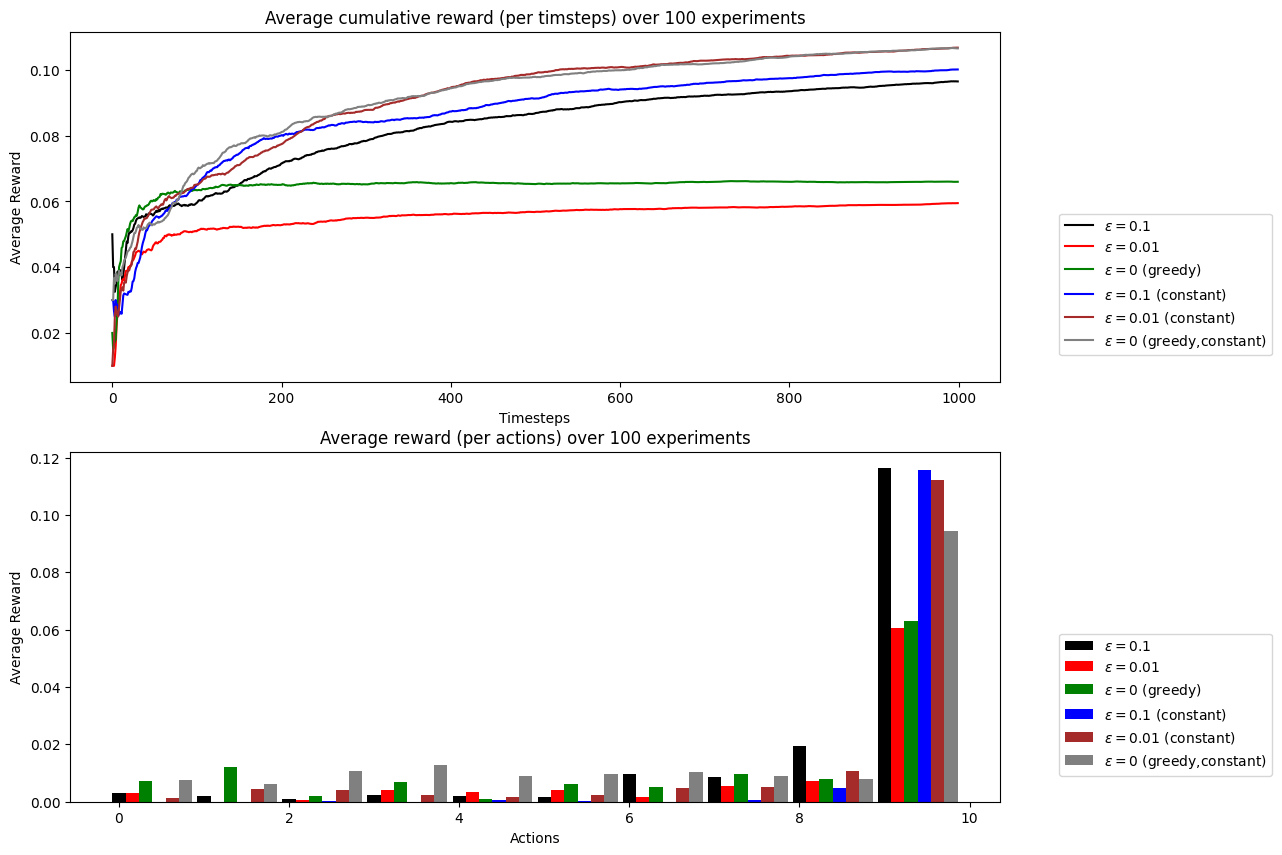

In [13]:
plt.tight_layout(pad=20.0)

fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# average reward per timesteps
plot_lines(ax[0], results, 
           x_values=range(timesteps), 
           y_key="average_reward_per_timesteps",
           title=f"Average cumulative reward (per timsteps) over {num_experiments} experiments",
           x_label="Timesteps", y_label="Average Reward")

# Average reward expectation of the model per timesteps
plot_bars(ax[1], results, 
           bins=np.linspace(0, num_actions - 1, num_actions), 
           y_key="average_reward_per_actions",
           title=f'Average reward (per actions) over {num_experiments} experiments',
           x_label="Actions", y_label="Average Reward")

